<a href="https://colab.research.google.com/github/Deok97/AI_personal_study/blob/main/Overfeat_Integrated_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google Drive와 연결시 사용

In [ ]:
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# %cd /content/gdrive/MyDrive/Colab\ Notebooks

/content/gdrive/MyDrive/Colab Notebooks




---



In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import 
import tensorflow.keras.backend as K
from tensorflow.keras.losses import MSE, CategoricalCrossentropy
from keras.datasets import mnist
from mnist_local_generator import mnist_localization_generator
from utils import *
import matplotlib.pyplot as plt
from google.colab import drive

### custom mnist load 파일인 mnist_localization_generator.py으로 mnist 데이터 불러오기

In [2]:
"""

Signature: mnist_localization_generator(train_shape, test_shape, background=True, n_sample=None, image_size_range=None, image_ratio_range=None)

Description:
mnist 데이터를 온라인으로 다운받고 다운받은 mnist 데이터를 지정된 크기의 이미지 안에 random 으로 붙입니다.
그리고 붙여진 위치 정보를 반환합니다.
train 이미지와 test 이미지 모두 진행됩니다.

"""

mnist_localization_generator?

In [3]:
"""
Args:
    train_shape : tuple , (H, W), train image dataset output 형태
    test_shape : tuple , (H, W), test image dataset output 형태
    background : bool, background 정보가 포함되게 할지 아닐지를 결정,
        True 시 이미지와 라벨 마지막에 약 10 정도의 백그라운드 정보를 추가합니다.
    n_sample :  int or None, 몇 개의 데이터만 사용할 지 결정합니다. 디버그시 사용합니다.
    image_size_range : tuple, (size_min:int, size_max:int),
        이미지의 size 범위 값을 제공합니다. 해당 값을 min 값 부터 max 값까지 하나의 값을 추출합니다.
    image_ratio_range : tuple, (ratio_min:float, ratio_maxfloat),
        이미지의 ratio 범위 값을 제공합니다. 해당 값을 min 값 부터 max 값까지 하나의 값을 추출합니다.

:return:
    train_images: ndarray, 4d array, shape = (N, H, W, C (단 C=1))
    train_cls_true: ndarray, 2d array, shape = (N, 1, 1, 11)
    train_reg_true: ndarray, 2d array, shape =(N, 1, 1 , 4), x1, y1, x2, y2  좌표 형태를 가짐
    test_images: ndarray, 4d array, shape = (N, H, W, C (단 C=1))
    test_cls_true: ndarray, 2d array, shape = (N, 1, 1, 11)
    test_reg_true: ndarray, 2d array, shape = (N, 1, 1, 4), x1, y1, x2, y2  좌표 형태를 가짐

"""

# 훈련 이미지, 시험 이미지는 (231, 231) size을 갖음
# background가 0.1*n_sample 개 만큼 추가된 데이터를 갖음
# background 데이터의 클래스 인덱스는 11
(train_imgs, train_cls, train_reg), (test_imgs, test_cls, test_reg) = \
mnist_localization_generator(train_shape=(231, 231),
                             test_shape=(231, 231),
                             background=True,
                             n_sample=1000)

배경 class가 포함되어 class 는 11로 설정 되어 있습니다.
11501568/11490434 [==============================] - 0s 0us/step


100%|██████████| 1000/1000 [00:02<00:00, 357.24it/s]


object 가 없는 background 이미지를 추가합니다.(전체 이미지의 10%)
background 의 class 는 11로 설정 되어 있습니다.
background 의 regression 는 (0,0,0,0)로 설정 되어 있습니다.


100%|██████████| 100/100 [00:00<00:00, 361.42it/s]


### 통합 모델인 Detection 모델은 Classification과 Localizaiton 통합 데이터를 입력으로 받아야함

In [5]:
train_imgs.shape, train_cls.shape, train_reg.shape

((1100, 231, 231, 1), (1100, 1, 1, 11), (1100, 1, 1, 4))

In [29]:
train_reg_cls = np.concatenate([train_reg, train_cls], axis=-1)
test_reg_cls = np.concatenate([test_reg, test_cls], axis=-1)
train_reg_cls.shape, train_reg_cls.shape

pos_mask = train_reg_cls[..., -1] !=1 # pos_mask: (1100, 1, 1)
pos_mask = np.squeeze(pos_mask) # pos_mask (1100, )
train_imgs = train_imgs[pos_mask] # pos_mask[1000:]는 False로 구성
train_reg_cls = train_reg_cls[pos_mask] # 배경 데이터를 제외하고 학습

In [30]:
train_reg_cls.shape, test_reg_cls.shape

((1000, 1, 1, 15), (1100, 1, 1, 15))

# Integrated Model Design from Fast Classification + Localization Model
출처: https://arxiv.org/abs/1312.6229  
The main difference with the localization task, is the necessity to predict a background class when no object is present


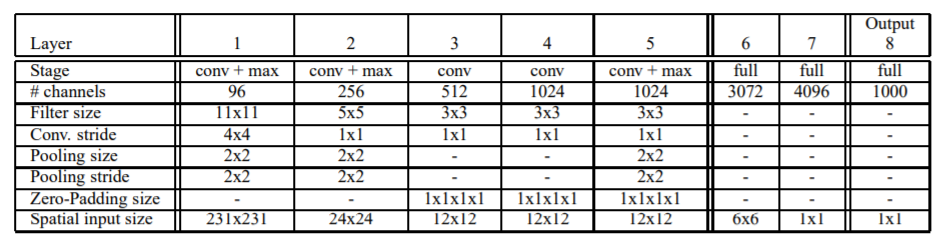

In [90]:
def overfeat_itg(true_reg_cls, pred_reg_cls):
  true_reg = true_reg_cls[..., :4]
  true_cls = true_reg_cls[..., 4:]
  pred_reg = pred_reg_cls[..., :4]
  pred_cls = pred_reg_cls[..., 4:]

  mse = MSE(true_reg, pred_reg)
  mse_ = tf.math.reduce_mean(mse)

  cee = CategoricalCrossentropy()
  cee_ = cee(true_cls, pred_cls)

  loss = mse_*0.01 + cee_

  return loss

In [91]:
K.clear_session()

# Overfeat 논문에서는 FC Layer을 Convolutional Layer로 변환
# Fully Convolutional Network을 구축
# input layer
# Our model uses the same fixed input size approach proposed by Krizhevsky et al(AlexNet)
# -> (231, 231)
input_ = Input(shape=(231, 231, 1))

# Backbone - 1st layer
# The weights in the network are initialized randomly with (µ, σ) = (0, 1 × 10−2) -> kernel_initializer=RandomNormal(0, 0.01)
# ℓ2 weight decay of 0.00001 -> kernel_regularizer=l2(0.00001)
conv_0 = Conv2D(filters=96/8, kernel_size=(11, 11), padding='valid', strides=4, activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(input_)
max_0 = MaxPooling2D(pool_size=2, strides=2)(conv_0)

# Backbone - 2nd layer
conv_1 = Conv2D(filters=256/8, kernel_size = 5, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_0)
max_1 = MaxPooling2D(pool_size=2, strides=2)(conv_1)

# Backbone - 3rd layer
conv_2 = Conv2D(filters = 512/8, kernel_size=3, strides = 1, padding='same', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_1)

# Backbone - 4th layer
conv_3 = Conv2D(filters = 1024/8, kernel_size=3, strides = 1, padding='same', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_2)

# Backbone - 5th layer
conv_4 = Conv2D(filters=1024/8, kernel_size = 3, strides=1, padding='same', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_3)
max_2 = MaxPooling2D(pool_size=2, strides=2)(conv_4)

In [92]:
# Localization - header 1
conv_5 = Conv2D(filters=4096/8, kernel_size = 6, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_2)

# Localization - header 2
conv_6 = Conv2D(filters=1024/8, kernel_size = 1, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_5)

# Localization - header 3; output layer
output_loc = Conv2D(filters=4, kernel_size = 1, strides=1, padding='valid', activation=None)(conv_6)

In [93]:
# Classification - header 1
conv_5 = Conv2D(filters=4096/8, kernel_size = 6, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_2)

# Classification - header 2
conv_6 = Conv2D(filters=1024/8, kernel_size = 1, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_5)

# Classification - header 3; output layer
output_cls = Conv2D(filters=11, kernel_size = 1, strides=1, padding='valid', activation='softmax')(conv_6)

## 모델 컴파일

In [94]:
output_ = Concatenate()([output_loc, output_cls])
model = Model(input_, output_)

# Adam implicitly performs coordinate-wise gradient clipping
model.compile(optimizer='adam', loss=overfeat_itg, metrics=[overfeat_itg])

print(model.summary())

print(output_)

"""
반영 안된 사항
  - The learning rate is successively decreased by a factor of 0.5 after (30, 50, 60, 70, 80) epochs -> learning rate scheduler
  - We extract 5 random crops (and their horizontal flips) of size 221x221 pixels
  - We present these(pixels) to the network n mini-batches of size 128
  - DropOut with a rate of 0.5 is employed on the fully connected layers (6th and 7th) in the classifier
    -> DropOut은 Fully Connected Layers을 Convolutional Layers로 변경하면서 적용 효과가 달라지게 됨.
"""

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 231, 231, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 56, 56, 12)   1464        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 28, 28, 12)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 32)   9632        ['max_pooling2d[0][0]']      

'\n반영 안된 사항\n  - The learning rate is successively decreased by a factor of 0.5 after (30, 50, 60, 70, 80) epochs -> learning rate scheduler\n  - We extract 5 random crops (and their horizontal flips) of size 221x221 pixels\n  - We present these(pixels) to the network n mini-batches of size 128\n  - DropOut with a rate of 0.5 is employed on the fully connected layers (6th and 7th) in the classifier\n    -> DropOut은 Fully Connected Layers을 Convolutional Layers로 변경하면서 적용 효과가 달라지게 됨.\n'

## 모델 학습

In [ ]:
model.fit(train_imgs, train_reg_cls, batch_size=32, epochs=50)

Epoch 1/50
32/32 [==============================] - 22s 649ms/step - loss: 82.3392 - overfeat_itg: 82.5251
Epoch 2/50
32/32 [==============================] - 21s 651ms/step - loss: 31.0394 - overfeat_itg: 30.4728
Epoch 3/50
32/32 [==============================] - 27s 851ms/step - loss: 7.8120 - overfeat_itg: 7.7410
Epoch 4/50
32/32 [==============================] - 21s 648ms/step - loss: 6.0995 - overfeat_itg: 6.0621
Epoch 5/50
32/32 [==============================] - 21s 646ms/step - loss: 5.5255 - overfeat_itg: 5.5240
Epoch 6/50
32/32 [==============================] - 21s 652ms/step - loss: 5.8013 - overfeat_itg: 5.7664
Epoch 7/50
32/32 [==============================] - 21s 646ms/step - loss: 4.7294 - overfeat_itg: 4.7353
Epoch 8/50
32/32 [==============================] - 21s 641ms/step - loss: 4.6267 - overfeat_itg: 4.6379
Epoch 9/50
32/32 [==============================] - 20s 637ms/step - loss: 3.8611 - overfeat_itg: 3.8413
Epoch 10/50
32/32 [==============================] 

In [82]:
pred_reg_cls = model.predict(train_imgs[:10])
print(pred_reg_cls.shape)
pred_reg_cls = np.squeeze(pred_reg_cls)
print(pred_reg_cls.shape)

(10, 1, 1, 15)
(10, 15)


In [85]:
def showPreds_reg(pred_reg_cls, indexArray):
  pred_reg = pred_reg_cls[..., :4]
  pred_cls = pred_reg_cls[..., 4:]
  print(pred_cls.shape)
  for index in indexArray:
    cls = np.argmax(pred_cls[index])
    print(cls.shape)
    xyxy_coord = xywh2xyxy(pred_reg[index]) # from utils.py; (cx, cy, w, h) -> (xmin, ymin, xmax, ymax)
    rect_img = draw_rectangle(train_imgs[index, ..., 0], xyxy_coord) # from utils.py; img, coord을 입력 받아 Bounding box 그려주는 함수

    plt.figure()
    plt.imshow(rect_img)
    plt.title('prediction class: {}'.format(cls))

(10, 11)
(11,)
(11,)
(11,)
(11,)
(11,)


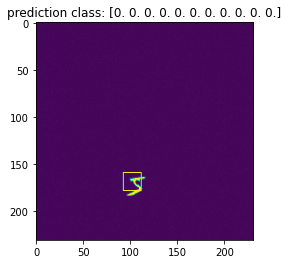

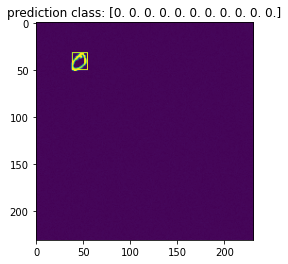

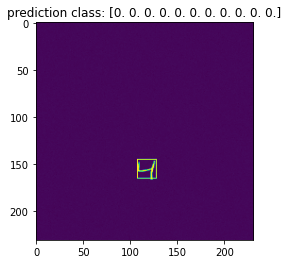

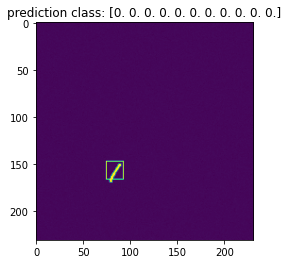

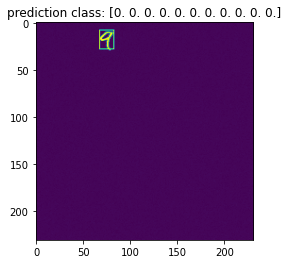

In [86]:
indexArray = [0, 1, 2, 3, 4]
showPreds_reg(pred_reg_cls, indexArray)